# Train a Quantized MLP on UNSW-NB15 with Brevitas

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

In this notebook, we will show how to create, train and export a quantized Multi Layer Perceptron (MLP) with quantized weights and activations with [Brevitas](https://github.com/Xilinx/brevitas).
Specifically, the task at hand will be to label network packets as normal or suspicious (e.g. originating from an attacker, virus, malware or otherwise) by training on a quantized variant of the UNSW-NB15 dataset. 

**You won't need a GPU to train the neural net.** This MLP will be small enough to train on a modern x86 CPU, so no GPU is required to follow this tutorial  Alternatively, we provide pre-trained parameters for the MLP if you want to skip the training entirely.


## A quick introduction to the task and the dataset

*The task:* The goal of [*network intrusion detection*](https://ieeexplore.ieee.org/abstract/document/283931) is to identify, preferably in real time, unauthorized use, misuse, and abuse of computer systems by both system insiders and external penetrators. This may be achieved by a mix of techniques, and machine-learning (ML) based techniques are increasing in popularity. 

*The dataset:* Several datasets are available for use in ML-based methods for intrusion detection.
The **UNSW-NB15** is one such dataset created by the Australian Centre for Cyber Security (ACCS) to provide a comprehensive network based data set which can reflect modern network traffic scenarios. You can find more details about the dataset on [its homepage](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/).

*Performance considerations:* FPGAs are commonly used for implementing high-performance packet processing systems that still provide a degree of programmability. To avoid introducing bottlenecks on the network, the DNN implementation must be capable of detecting malicious ones at line rate, which can be millions of packets per second, and is expected to increase further as next-generation networking solutions provide increased
throughput. This is a good reason to consider FPGA acceleration for this particular use-case.

## Outline
-------------

* [Load the UNSW_NB15 Dataset](#load_dataset) 
* [Define a PyTorch Device](#define_pytorch_device)
* [Define the Quantized MLP Model](#define_quantized_mlp)
* [Define Train and Test  Methods](#train_test)
    * [(Option 1) Train the Model from Scratch](#train_scratch)
    * [(Option 2) Load Pre-Trained Parameters](#load_pretrained)
* [Network Surgery Before Export](#network_surgery)
* [Export to QONNX and Conversion to FINN-ONNX](#export_qonnx)

In [57]:
import os
import onnx
import torch

model_dir = "./"

**This is important -- always import onnx before torch**. This is a workaround for a [known bug](https://github.com/onnx/onnx/issues/2394).

# Load the UNSW_NB15 Dataset <a id='load_dataset'></a>

### Dataset Quantization <a id='dataset_qnt'></a>

The goal of this notebook is to train a Quantized Neural Network (QNN) to be later deployed as an FPGA accelerator generated by the FINN compiler. Although we can choose a variety of different precisions for the input, [Murovic and Trost](https://ev.fe.uni-lj.si/1-2-2019/Murovic.pdf) have previously shown we can actually binarize the inputs and still get good (90%+) accuracy.

We will create a binarized representation for the dataset by following the procedure defined by Murovic and Trost, which we repeat briefly here:

* Original features have different formats ranging from integers, floating numbers to strings.
* Integers, which for example represent a packet lifetime, are binarized with as many bits as to include the maximum value. 
* Another case is with features formatted as strings (protocols), which are binarized by simply counting the number of all different strings for each feature and coding them in the appropriate number of bits.
* Floating-point numbers are reformatted into fixed-point representation.
* In the end, each sample is transformed into a 593-bit wide binary vector. 
* All vectors are labeled as bad (0) or normal (1)

Following Murovic and Trost's open-source implementation provided as a Matlab script [here](https://github.com/TadejMurovic/BNN_Deployment/blob/master/cybersecurity_dataset_unswb15.m), we've created a [Python version](dataloader_quantized.py).

<font color="red">**Live FINN tutorial:** Downloading the original dataset and quantizing it can take some time, so we provide a download link to the pre-quantized version for your convenience. </font>

In [58]:
! wget -O unsw_nb15_binarized.npz https://zenodo.org/record/4519767/files/unsw_nb15_binarized.npz?download=1

--2025-05-11 13:09:29--  https://zenodo.org/record/4519767/files/unsw_nb15_binarized.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4519767/files/unsw_nb15_binarized.npz [following]
--2025-05-11 13:09:29--  https://zenodo.org/records/4519767/files/unsw_nb15_binarized.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 13391907 (13M) [application/octet-stream]
Saving to: ‘unsw_nb15_binarized.npz’

unsw_nb15_binarized 100%[===================>]  12.77M  9.72MB/s    in 1.3s    

2025-05-11 13:09:30 (9.72 MB/s) - ‘unsw_nb15_binarized.npz’ saved [13391907/13391907]



We can extract the binarized numpy arrays from the .npz archive and wrap them as a PyTorch `TensorDataset` as follows:

In [59]:
import numpy as np
from torch.utils.data import TensorDataset

def get_preqnt_dataset(data_dir: str, train: bool):
    unsw_nb15_data = np.load(data_dir + "/unsw_nb15_binarized.npz")
    if train:
        partition = "train"
    else:
        partition = "test"
    part_data = unsw_nb15_data[partition].astype(np.float32)
    part_data = torch.from_numpy(part_data)
    part_data_in = part_data[:, :-1]
    part_data_out = part_data[:, -1]
    return TensorDataset(part_data_in, part_data_out)

train_quantized_dataset = get_preqnt_dataset(".", True)
test_quantized_dataset = get_preqnt_dataset(".", False)

print("Samples in each set: train = %d, test = %s" % (len(train_quantized_dataset), len(test_quantized_dataset))) 
print("Shape of one input sample: " +  str(train_quantized_dataset[0][0].shape))

Samples in each set: train = 175341, test = 82332
Shape of one input sample: torch.Size([593])


## Set up DataLoader

Following either option, we now have access to the quantized dataset. We will wrap the dataset in a PyTorch `DataLoader` for easier access in batches.

In [60]:
from torch.utils.data import DataLoader, Dataset

batch_size = 1000

# dataset loaders
train_quantized_loader = DataLoader(train_quantized_dataset, batch_size=batch_size, shuffle=True)
test_quantized_loader = DataLoader(test_quantized_dataset, batch_size=batch_size, shuffle=False)    

In [61]:
count = 0
for x,y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([1000, 593])
Label shape for 1 batch: torch.Size([1000])


# Define a PyTorch Device <a id='define_pytorch_device'></a> 

GPUs can significantly speed-up training of deep neural networks. We check for availability of a GPU and if so define it as target device.

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


# Define the Quantized MLP Model <a id='define_quantized_mlp'></a>

We'll now define an MLP model that will be trained to perform inference with quantized weights and activations.
For this, we'll use the quantization-aware training (QAT) capabilities offered by [Brevitas](https://github.com/Xilinx/brevitas).

Our MLP will have four fully-connected (FC) layers in total: three hidden layers with 64 neurons, and a final output layer with a single output, all using 2-bit weights. We'll use 2-bit quantized ReLU activation functions, and apply batch normalization between each FC layer and its activation.

In case you'd like to experiment with different quantization settings or topology parameters, we'll define all these topology settings as variables.

In [63]:
input_size = 593      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 2
act_bit_width = 2
num_classes = 1    

Now we can define our MLP using the layer primitives provided by Brevitas:

In [64]:
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn

# Setting seeds for reproducibility
torch.manual_seed(0)

model = nn.Sequential(
      QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden1),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden2),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden3),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden3, num_classes, bias=True, weight_bit_width=weight_bit_width)
)

model.to(device)

Sequential(
  (0): QuantLinear(
    in_features=593, out_features=64, bias=True
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
 

Note that the MLP's output is not yet quantized. Even though we want the final output of our MLP to be a binary (0/1) value indicating the classification, we've only defined a single-neuron FC layer as the output. While training the network we'll pass that output through a sigmoid function as part of the loss criterion, which [gives better numerical stability](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). Later on, after we're done training the network, we'll add a quantization node at the end before we export it to FINN.

# Define Train and Test  Methods  <a id='train_test'></a>
The train and test methods will use a `DataLoader`, which feeds the model with a new predefined batch of training data in each iteration, until the entire training data is fed to the model. Each repetition of this process is called an `epoch`.

In [65]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())
        loss = criterion(output, target.unsqueeze(1))
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
           
    return losses

In [66]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            output_orig = model(inputs.float())
            # run the output through sigmoid
            output = torch.sigmoid(output_orig)  
            # compare against a threshold of 0.5 to generate 0/1
            pred = (output.detach().cpu().numpy() > 0.5) * 1
            target = target.cpu().float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

# Train the QNN <a id="train_qnn"></a>

We provide two options for training below: you can opt for training the model from scratch (slower) or use a pre-trained model (faster). The first option will give more insight into how the training process works, while the second option will likely give better accuracy.

## (Option 1, slower) Train the Model from Scratch <a id="train_scratch"></a>


Before we start training our MLP we need to define some hyperparameters. Moreover, in order to monitor the loss function evolution over epochs, we need to define a method for it. As mentioned earlier, we'll use a loss criterion which applies a sigmoid function during the training phase (`BCEWithLogitsLoss`). For the testing phase, we're manually computing the sigmoid and thresholding at 0.5.

In [67]:
num_epochs = 10
lr = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [68]:
# loss criterion and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

In [69]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_quantized_loader, optimizer,criterion)
        test_acc = test(model, test_quantized_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 0.132504 test accuracy = 0.689659: 100%|█| 10/10 [00:58<00:00,  


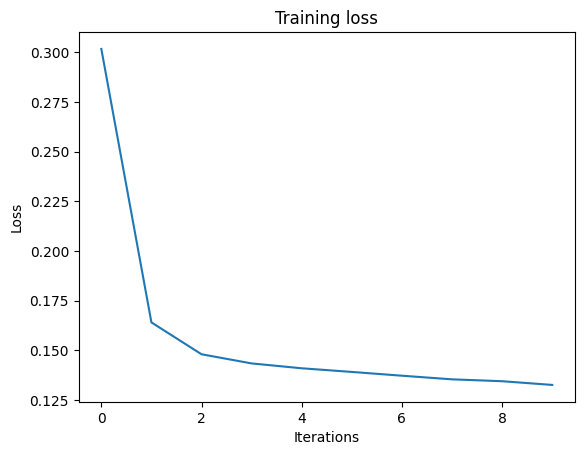

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

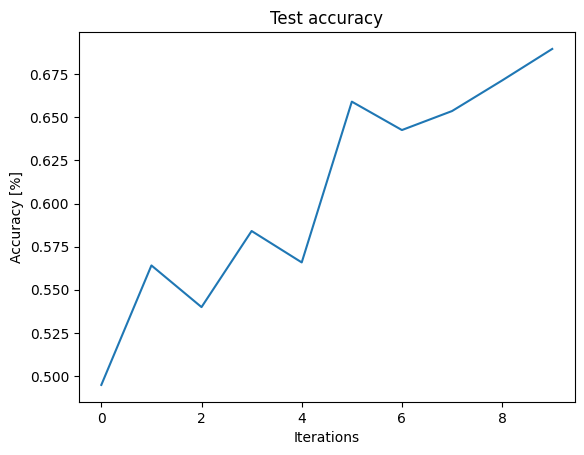

In [71]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [72]:
test(model, test_quantized_loader)

0.689658941845212

In [73]:
# Save the Brevitas model to disk
torch.save(model.state_dict(), "state_dict_self-trained.pth")

## (Option 2, faster) Load Pre-Trained Parameters <a id="load_pretrained"></a>

Instead of training from scratch, you can also use pre-trained parameters we provide here. These parameters should achieve ~91.9% test accuracy.

In [74]:
import os
import torch

# Make sure the model is on CPU before loading a pretrained state_dict
model = model.cpu()

# Load pretrained weights
trained_state_dict = torch.load(model_dir + "/state_dict.pth")["models_state_dict"][0]

model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

In [75]:
# Move the model back to it's target device
model.to(device)

# Test for accuracy
test(model, test_quantized_loader)

0.9188772287810328

**Why do these parameters give better accuracy vs training from scratch?** Even with the topology and quantization fixed, achieving good accuracy on a given dataset requires [*hyperparameter tuning*](https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d) and potentially running training for a long time. The "training from scratch" example above is only intended as a quick example, whereas the pretrained parameters are obtained from a longer training run using the [determined.ai](https://determined.ai/) platform for hyperparameter tuning.

# Network Surgery Before Export <a id="network_surgery"></a>

Sometimes, it's desirable to make some changes to our trained network prior to export (this is known in general as "network surgery"). This depends on the model and is not generally necessary, but in this case we want to make a couple of changes to get better results with FINN.

In [76]:
# Move the model to CPU before surgery
model = model.cpu()

Let's start by padding the input. Our input vectors are 593-bit, which will make folding (parallelization) for the first layer a bit tricky since 593 is a prime number. So we'll pad the weight matrix of the first layer with seven 0-valued columns to work with an input size of 600 instead. When using the modified network we'll similarly provide inputs padded to 600 bits.

In [77]:
from copy import deepcopy

modified_model = deepcopy(model)

W_orig = modified_model[0].weight.data.detach().numpy()
W_orig.shape

(64, 593)

In [78]:
import numpy as np

# pad the second (593-sized) dimensions with 7 zeroes at the end
W_new = np.pad(W_orig, [(0,0), (0,7)])
W_new.shape

(64, 600)

In [79]:
modified_model[0].weight.data = torch.from_numpy(W_new)
modified_model[0].weight.shape

torch.Size([64, 600])

Next, we'll modify the expected input/output ranges. In FINN, we prefer to work with bipolar {-1, +1} instead of binary {0, 1} values. To achieve this, we'll create a "wrapper" model that handles the pre/postprocessing as follows:

* on the input side, we'll pre-process by (x + 1) / 2 in order to map incoming {-1, +1} inputs to {0, 1} ones which the trained network is used to. Since we're just multiplying/adding a scalar, these operations can be [*streamlined*](https://finn.readthedocs.io/en/latest/nw_prep.html#streamlining-transformations) by FINN and implemented with no extra cost.

* on the output side, we'll add a binary quantizer which maps everthing below 0 to -1 and everything above 0 to +1. This is essentially the same behavior as the sigmoid we used earlier, except the outputs are bipolar instead of binary.

In [80]:
from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        self.qnt_output = QuantIdentity(
            quant_type='binary', 
            scaling_impl_type='const',
            bit_width=1, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        x = (x + torch.tensor([1.0]).to(x.device)) / 2.0  
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}     
        return out_final

model_for_export = CybSecMLPForExport(modified_model)
model_for_export.to(device)

CybSecMLPForExport(
  (pretrained): Sequential(
    (0): QuantLinear(
      in_features=593, out_features=64, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              (stats): _Stats(
                (stats_impl

In [81]:
def test_padded_bipolar(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            # pad inputs to 600 elements
            input_padded = torch.nn.functional.pad(inputs, (0,7,0,0))
            # convert inputs to {-1,+1}
            input_scaled = 2 * input_padded - 1
            # run the model
            output = model(input_scaled.float())
            y_pred.extend(list(output.flatten().cpu().numpy()))
            # make targets bipolar {-1,+1}
            expected = 2 * target.float() - 1
            expected = expected.cpu().numpy()
            y_true.extend(list(expected.flatten()))
        
    return accuracy_score(y_true, y_pred)

In [82]:
test_padded_bipolar(model_for_export, test_quantized_loader)

0.9188772287810328

# Export to QONNX and Conversion to FINN-ONNX <a id="export_qonnx" ></a>


[ONNX](https://onnx.ai/) is an open format built to represent machine learning models, and the FINN compiler expects an ONNX model as input. We'll now export our network into ONNX to be imported and used in FINN for the next notebooks. Note that the particular ONNX representation used for FINN differs from standard ONNX, you can read more about this [here](https://finn.readthedocs.io/en/latest/internals.html#intermediate-representation-finn-onnx).

You can see below how we export a trained network in Brevitas into a FINN-compatible ONNX representation (QONNX). QONNX is the format we can export from Brevitas, to feed it into the FINN compiler, we will need to make a conversion to the FINN-ONNX format which is the intermediate representation the compiler works on. The conversion of the FINN-ONNX format is a FINN compiler transformation and to be able to apply it to our model, we will need to wrap it into [ModelWrapper](https://finn.readthedocs.io/en/latest/internals.html#modelwrapper). This is a wrapper around the ONNX model which provides several helper functions to make it easier to work with the model. Then we can call the conversion function to obtain the model in FINN-ONNX format.

In [83]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

ready_model_filename = model_dir + "/cybsec-mlp-ready.onnx"
input_shape = (1, 600)

# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
input_a = 2 * input_a - 1
scale = 1.0
input_t = torch.from_numpy(input_a * scale)

#Move to CPU before export
model_for_export.cpu()

# Export to ONNX
export_qonnx(
    model_for_export, export_path=ready_model_filename, input_t=input_t
)

# clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

# ModelWrapper
model = ModelWrapper(ready_model_filename)
# Setting the input datatype explicitly because it doesn't get derived from the export function
model.set_tensor_datatype(model.graph.input[0].name, DataType["BIPOLAR"])
model = model.transform(ConvertQONNXtoFINN())
model.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)

/home/surajkarki/Documents/My_Workspace/Coding_Works/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


Model saved to .//cybsec-mlp-ready.onnx


## View the Exported ONNX in Netron

Let's examine the exported ONNX model with [Netron](https://github.com/lutzroeder/netron), which is a visualizer for neural networks and allows interactive investigation of network properties. For example, you can click on the individual nodes and view the properties. Particular things of note:

* The input tensor "0" is annotated with `quantization: finn_datatype: BIPOLAR`
* The input preprocessing (x + 1) / 2 is exported as part of the network (initial `Add` and `Div` layers)
* Brevitas `QuantLinear` layers are exported to ONNX as `MatMul`. We've exported the padded version; shape of the first MatMul node's weight parameter is 600x64
* The weight parameters (second inputs) for MatMul nodes are annotated with `quantization: finn_datatype: INT2`
* The quantized activations are exported as `MultiThreshold` nodes with `domain=qonnx.custom_op.general`
* There's a final `MultiThreshold` node with threshold=0 to produce the final bipolar output (this is the `qnt_output` from `CybSecMLPForExport`

In [84]:
from finn.util.visualization import showInNetron

showInNetron(ready_model_filename)

Stopping http://0.0.0.0:8081
Serving './/cybsec-mlp-ready.onnx' at http://0.0.0.0:8081


## That's it! <a id="thats_it" ></a>
You created, trained and tested a quantized MLP that is ready to be loaded into FINN, congratulations! You can now proceed to the next notebook.